# Permits issued over time by area

I wanted to create a map that showed which areas of the city were decreasing permits issued, and which were increasing the number of permits issued.

To do this, I created a linear trendline for the data for each zip code. Then mapped the slope of the trendline onto a map of zip codes.



In [11]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import numpy as np


In [12]:
# Import building permits
read_columns = ['Zip Code', 'Issuance Date',
                'LATITUDE', 'LONGITUDE', 'Job Type']
new_or_a1 = ['NB', 'A1']

permits_df = pd.read_csv('DOB_Permit_Issuance.csv', usecols=read_columns)
permits_df['Issuance Date'] = pd.to_datetime(permits_df['Issuance Date'], format='mixed')
permits_df = permits_df[permits_df['Job Type'].isin(new_or_a1)]


In [13]:
# Import Zip code shapes data.

zip_read_columns = ['ZIPCODE', 'POPULATION', 'SHAPE_AREA', 'geometry']
zip_shapes = gpd.read_file(
    './zip_shapes/ZIP_CODE_040114.shp', include_fields=zip_read_columns)
zip_shapes = zip_shapes.to_crs('EPSG:4326')
zip_shapes = zip_shapes.rename(columns={"ZIPCODE": "ZIP Code"})
zip_shapes['ZIP Code'] = zip_shapes['ZIP Code'].astype(float)


In [14]:
# Create df for slopes on building permits.
permits_by_year_and_zip = permits_df.groupby(
    [permits_df['Issuance Date'].dt.year, 'Zip Code']).size().reset_index(name="count")
permits_by_year_and_zip_pivot = permits_by_year_and_zip.pivot(
    index='Issuance Date', columns='Zip Code', values='count')

permits_final = permits_by_year_and_zip_pivot.dropna(how='all')

slope_df = pd.DataFrame()

for col in permits_final.columns:
    x = permits_final.index
    y = permits_final[col].fillna(0)

    # Fit a linear regression model
    coeffs = np.polyfit(x, y, deg=1)

    slope_df = pd.concat([slope_df, pd.DataFrame(
        {'ZIP Code': col, 'slope': coeffs[0]}, index=[col])])


Text(0.5, 1.0, 'Trend in permits issued since 1989')

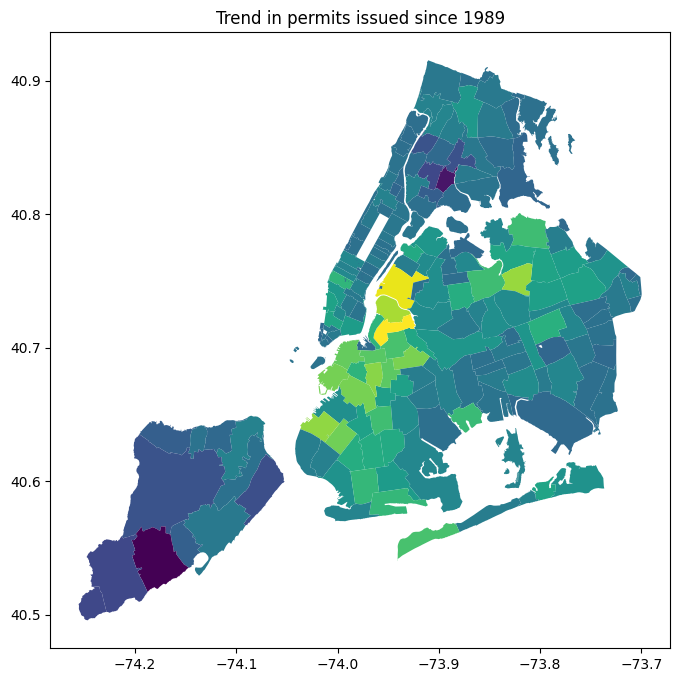

In [17]:
joined_df = zip_shapes.join(slope_df.set_index('ZIP Code'), on='ZIP Code')

plot = joined_df.plot(column='slope', figsize=(8, 8))
plot.set_title("Trend in permits issued since 1989")


# Analysis

We can see some zip codes are trending upwards substantially.

There are some additional factors that could improve this data, such as density, median income, demographics, etc.